# Unbalanced Neural Dual Solver

This tutorial shows how to use `OTT` to compute the Wasserstein-2 optimal transport map between continuous measures in Euclidean space in an unbalanced manner.
{class}`~ott.solvers.nn.neuraldual.W2NeuralDual` solves this
problem by optimizing parameterized Kantorovich dual potential functions
and returning a  {class}`~ott.problems.linear.potentials.DualPotentials`
object that can be used to transport unseen source data samples to its target distribution (or vice-versa) or compute the corresponding distance between source and target distribution.

In [1]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/ott-jax/ott@main

In [2]:
from dataclasses import dataclass
from functools import partial
import optax

import matplotlib.pyplot as plt
from IPython.display import clear_output, display

from ott.geometry import pointcloud
from ott.problems.linear.linear_problem import LinearProblem
from ott.problems.nn import dataset
from ott.solvers.nn import models, neuraldual
from ott.tools import plot

## Setup training and validation datasets

We apply the {class}`~ott.solvers.nn.neuraldual.W2NeuralDual` to compute the transport between toy datasets.
In order to solve the neural dual, we need to define our dataloaders. The only requirement is that the corresponding source and target train and validation datasets are *iterators* that provide samples of batches from the source and target measures.

Here, our data is "unbalanced", which means the mass is unevenly distributed among the respective mixtures. The following command generates this with OTT's pre-packaged loader for synthetic uniform data using {func}:`~ott.problems.nn.dataset.uniform_mixture_samplers`.

In [3]:
num_samples_visualize = 300
(
    train_dataloaders,
    valid_dataloaders,
    input_dim,
) = dataset.uniform_mixture_samplers(
    name_source="bottom",
    name_target="top",
    mixture_weights_source=[0.6, 0.4],
    mixture_weights_target=[0.4, 0.6],
    valid_batch_size=num_samples_visualize,
)

In the following, we visualize what we refer to as `unbalanced data`. In effect, the `mixture_weights_source` determines the concentration of the mass in the bottom left and the bottom right corner, respectively. If the both the first entry of `mixture_weights_source` and the second entry of `mixture_weights_target` is larger than 0.5, we will have to map across the diagonal from the bottom left to the top right to satisfy the marginal conditions. 

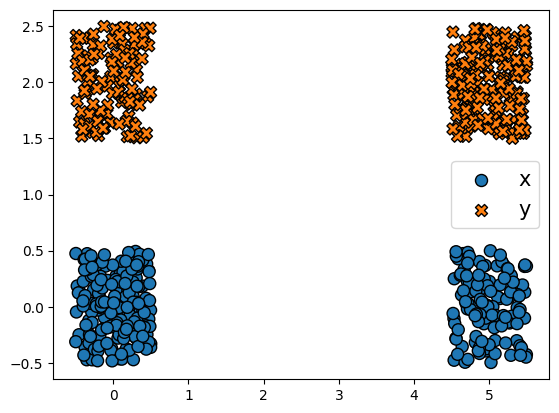

In [4]:
# Sample a batch for evaluation and plot it
eval_data_source = next(valid_dataloaders.source_iter)
eval_data_target = next(valid_dataloaders.target_iter)

geom = pointcloud.PointCloud(eval_data_source, eval_data_target)
ot_prob = LinearProblem(geom)

plott = plot.Plot(scale=75, show_lines=False)
_ = plott(ot_prob)

## Neural Optimal Transport

First, we solve the problem in a balanced way. We parameterize both $f$ and $g$ with {class}`~ott.solvers.nn.models.MLP` as suggested in {cite}`amos:23` with {attr}`~ott.solvers.nn.models.ModelBase.is_potential` set to True.
For more details on how to customize {class}`~ott.solvers.nn.models.MLP` and {class}`~ott.solvers.nn.neuraldual.W2NeuralDual`, we refer you to the documentation.

In [5]:
# initialize models and optimizers
num_train_iters = 10001

neural_f = models.MLP(is_potential=True, dim_hidden=[64, 64, 64, 64])
neural_g = models.MLP(is_potential=True, dim_hidden=[64, 64, 64, 64])

optimizer_f = optax.adamw(learning_rate=2e-4)
optimizer_g = optax.adamw(learning_rate=2e-4)

We then initialize the {class}`~ott.solvers.nn.neuraldual.W2NeuralDual` by passing the two {class}`~ott.solvers.nn.models.MLP` models parameterizing $f$ and $g$, as well as by specifying the input dimensions of the data and the number of training iterations to execute. Once the {class}`~ott.solvers.nn.neuraldual.W2NeuralDual` is initialized, we can obtain the neural {class}`~ott.problems.linear.potentials.DualPotentials` by passing the corresponding dataloaders to it.
For more details on how to configure the {class}`~ott.solvers.nn.neuraldual.W2NeuralDual`, we refer you to the documentation.

In [6]:
def training_callback(step, learned_potentials):
    # Callback function as the training progresses to visualize the couplings.
    if step % 1000 == 0:
        clear_output()
        print(f"Training iteration: {step}/{num_train_iters}")

        fig, ax = learned_potentials.plot_ot_map(
            eval_data_source,
            eval_data_target,
            forward=True,
        )
        display(fig)
        plt.close(fig)

        fig, ax = learned_potentials.plot_ot_map(
            eval_data_source,
            eval_data_target,
            forward=False,
        )
        display(fig)
        plt.close(fig)
        fig, ax = plt.subplots(figsize=(7, 4), facecolor="white")
        fig, ax = learned_potentials.plot_potential(
            ax=ax,
            forward=True,
            displacement=True,
            x_bounds=(-1, 6),
            y_bounds=(-1, 3),
        )
        display(fig)
        plt.close(fig)

With `tau_a` and `tau_b` we set the degree of unbalancedness in the source marginals and target marginals, respectively. These are used in the inner Sinkhorn loop {cite}`eyring:22`, {cite}`luebeck:22`. The default balanced training is recovered with `tau_a` and `tau_b` set to $1.0$.

<font color='#F2545B'>Execution of the following cell will probably take a few minutes, depending on your system and the number of training iterations.</font>

In [7]:
# setup neural dual
neural_dual_solver = neuraldual.W2NeuralDual(
    input_dim,
    neural_f,
    neural_g,
    optimizer_f,
    optimizer_g,
    num_train_iters=num_train_iters,
    tau_a=1.0,
    tau_b=1.0,
)
# training
learned_potentials = neural_dual_solver(
    *train_dataloaders,
    *valid_dataloaders,
    callback=training_callback,
)
clear_output()

The output of the solver, `learned_potentials`, is an instance of
{class}`~ott.problems.linear.potentials.DualPotentials`.
This  gives us access to the learned potentials and provides functions to compute and plot the forward and
inverse OT maps between the measures as well as the displacement potential.

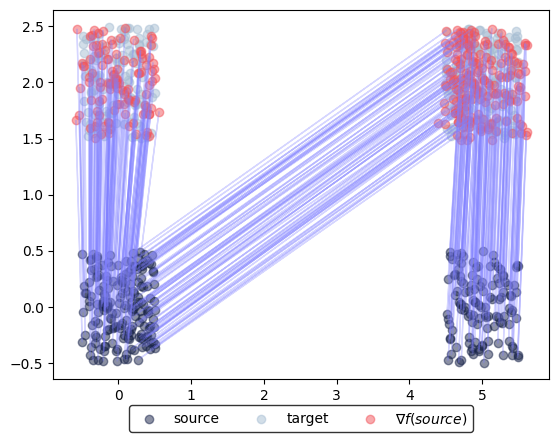

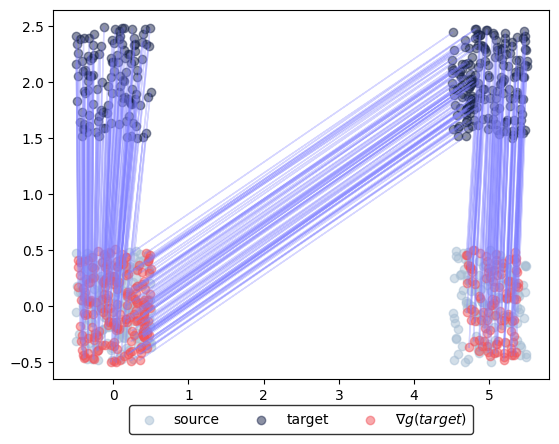

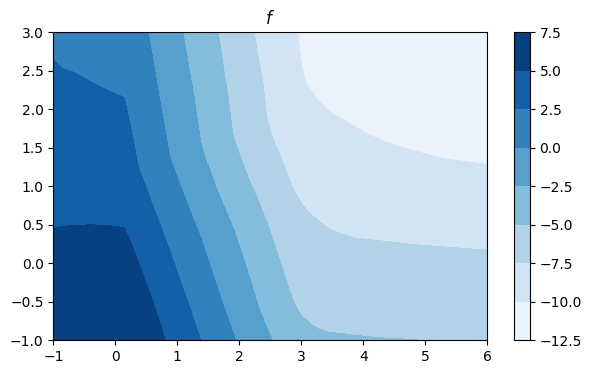

In [8]:
learned_potentials.plot_ot_map(
    eval_data_source,
    eval_data_target,
    forward=True,
)
learned_potentials.plot_ot_map(
    eval_data_source, eval_data_target, forward=False
)
fig, ax = plt.subplots(figsize=(7, 4), facecolor="white")
fig, ax = learned_potentials.plot_potential(
    ax=ax,
    forward=True,
    displacement=True,
    x_bounds=(-1, 6),
    y_bounds=(-1, 3),
);

We can see that, due to the unevenly distributed data, a partly diagonal potential is learned.

## Solve Neural Dual in an unbalanced manner

We now solve the problem in an unbalanced manner, therefore we set `tau_a` and `tau_b` $<1$. As we expect unbalancedness in both the source and the target to be of roughly the same magnitude, we set `tau_a` and `tau_b` to $0.99$. More parameters for the {class}ott.solvers.linear.sinkhorn.Sinkhorn (as well as how to scale the cost) can be passed via `sinkhorn_kwargs`. We set `recenter_potentials` to True to increase numeric stability.

<font color='#F2545B'>Execution of the following cell will probably take a few minutes, depending on your system and the number of training iterations.</font>

In [10]:
# initialize models and optimizers
num_train_iters = 10001

neural_f = models.MLP(is_potential=True, dim_hidden=[64, 64, 64, 64])
neural_g = models.MLP(is_potential=True, dim_hidden=[64, 64, 64, 64])

optimizer_f = optax.adamw(learning_rate=2e-4)
optimizer_g = optax.adamw(learning_rate=2e-4)

# setup neural dual
neural_dual_solver = neuraldual.W2NeuralDual(
    input_dim,
    neural_f,
    neural_g,
    optimizer_f,
    optimizer_g,
    num_train_iters=num_train_iters,
    tau_a=0.99,
    tau_b=0.99,
    sinkhorn_kwargs={"recenter_potentials": True},
)
# training
learned_potentials = neural_dual_solver(
    *train_dataloaders,
    *valid_dataloaders,
    callback=training_callback,
)
clear_output()

Again, we plot the potentials and the transport maps.

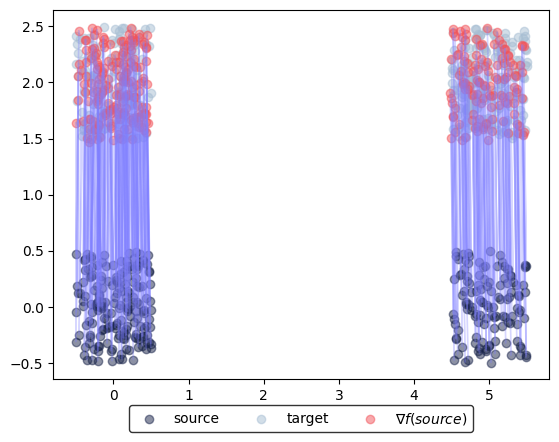

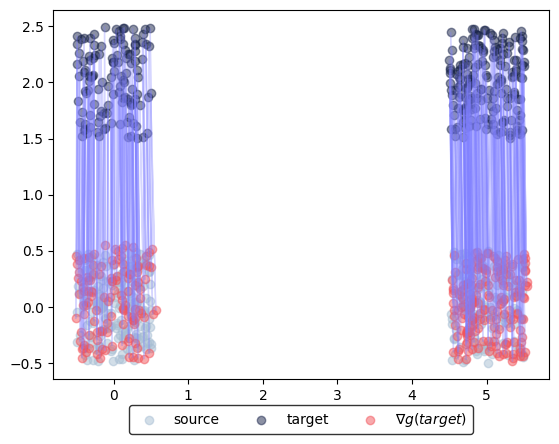

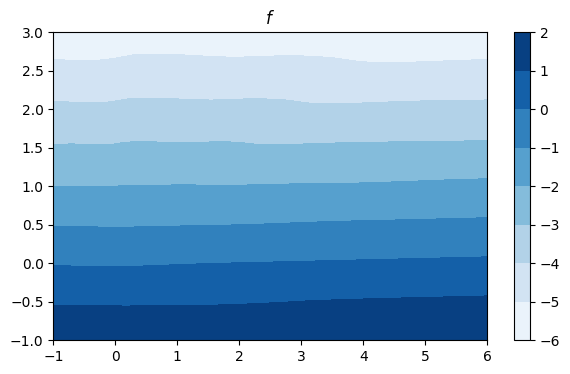

In [11]:
learned_potentials.plot_ot_map(
    eval_data_source,
    eval_data_target,
    forward=True,
)
learned_potentials.plot_ot_map(
    eval_data_source, eval_data_target, forward=False
)
fig, ax = plt.subplots(figsize=(7, 4), facecolor="white")
fig, ax = learned_potentials.plot_potential(
    ax=ax,
    forward=True,
    displacement=True,
    x_bounds=(-1, 6),
    y_bounds=(-1, 3),
);

As we can see, we don't map diagonally anymore, only vertically.